# Time Evolution

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    SkyModels,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel,
    GaussianSpatialModel
)
from gammapy.stats import significance, excess # utiles ?

from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

In [142]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
)

energy_axis_true = MapAxis.from_bounds(
    0.3, 200, 30, unit="TeV", name="energy", interp="log"
)

In [143]:
from pathlib import Path

# Directory for outputs

path = Path("../../../../gammapy_data/GC_variability2020/hap-fr")
path.mkdir(exist_ok=True)

pathm = Path(path/"mapdatasets")
pathm.mkdir(exist_ok=True)

pathp = Path(path/"parameter_stability")
pathp.mkdir(exist_ok=True)

## Creating the datasets

In [144]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

for year in range(2004,2020):
    
    filename = "mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year] = MapDataset.read(pathm/filename)

## Reading the model template

In [145]:
pathmo = Path(path/"models")
pathmo.mkdir(exist_ok=True)

#name = pathmo/"models_template.yaml"
#modelGC,modelG09, model_diff = SkyModels.read(name)

name = pathmo/"models_template_1cutoff.yaml"
modelGC,modelG09, modeldiff = SkyModels.read(name)

#name = pathmo/"models_template_2cutoff.yaml"
#modelGC,modelG09, modeldiff = SkyModels.read(name)

## Setting which parameters will vary

In [146]:
modelGC.parameters["index"].frozen = False
modelGC.parameters["lon_0"].frozen = True
modelGC.parameters["lat_0"].frozen = True
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["reference"].frozen = True 

modelG09.parameters["index"].frozen = True
modelG09.parameters["lon_0"].frozen = True
modelG09.parameters["lat_0"].frozen = True
modelG09.parameters["amplitude"].frozen = False

model_diff.parameters["index"].frozen = False
model_diff.parameters["norm"].frozen = True
model_diff.parameters["amplitude"].frozen = False
model_diff.parameters["reference"].frozen = True

In [147]:
# if there are cutoffs in the spectra

modelGC.parameters["lambda_"].frozen = True 
#model_diff.parameters["lambda_"].frozen = True

## Constructing the mask

In [148]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Applying the mask and the model template

In [149]:
for year in range(2004,2020):
    mapdataset_dict[year].fit_mask = fit_mask
    mapdataset_dict[year].models =  modelGC.copy() + modelG09.copy() +  model_diff.copy()
    mapdataset_dict[year].background_model.parameters['norm'].value = 1.0

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/cube/psf_kernel.py:109: RuntimeWarning: invalid value encountered in true_divide
  img += vals.value / vals.sum().value


# Fitting the datasets

In [150]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()

    rescov = fit.covariance()
    #ampSGRA = mapdataset.models.parameters[3]
    #ampdiff = mapdataset.models.parameters[12]
    #normbkg = mapdataset.background_model.parameters['norm']
    
    #cov= rescov.parameters.get_subcovariance([ampSGRA, ampdiff, normbkg])
    
    return table, rescov, result

In [ ]:
%%time

results_per_year = dict()
results = []
cov_per_year = dict()


for year in range(2004,2020):
    
    table, cov, result = fit_dataset(mapdataset_dict[year])
    
    results.append(result)
    
    results_per_year[year] = table
    
    cov_per_year[year] = cov
    

In [ ]:
years = []
for year in range(2004,2020):
    if results[year-2004].message =='Optimization terminated successfully.':
        years.append(year)

In [ ]:
table

# Extracting parameters (only one cell to run)

In [72]:
# Spectral models without cutoffs (indexes fixed)

ampsGC = []
ampsGC_err = []
ampsdiff = []
ampsdiff_err = []
norms = []
norms_err = []


for year in years:

    ampsGC.append(results_per_year[year]['value'][3])
    ampsGC_err.append(results_per_year[year]['error'][3])
    ampsdiff.append(results_per_year[year]['value'][12])
    ampsdiff_err.append(results_per_year[year]['error'][12])
   
    norms.append(results_per_year[year]['value'][14])
    norms_err.append(results_per_year[year]['error'][14])

In [131]:
# Spectral models without cutoffs (indexes unfrozen)

indexGC = []
indexGC_err = []
ampsGC = []
ampsGC_err = []


indexdiff = []
indexdiff_err = []
ampsdiff = []
ampsdiff_err = []
norms = []
norms_err = []


for year in years:
    indexGC.append(results_per_year[year]['value'][2])
    indexGC_err.append(results_per_year[year]['error'][2])
    ampsGC.append(results_per_year[year]['value'][3])
    ampsGC_err.append(results_per_year[year]['error'][3])
    
    indexdiff.append(results_per_year[year]['value'][11])
    indexdiff_err.append(results_per_year[year]['error'][11])
    ampsdiff.append(results_per_year[year]['value'][12])
    ampsdiff_err.append(results_per_year[year]['error'][12])
   
    norms.append(results_per_year[year]['value'][14])
    norms_err.append(results_per_year[year]['error'][14])

In [ ]:
# Spectral models with a cutoff for the central source (both indexes unfrozen)

indexGC = []
indexGC_err = []
ampsGC = []
ampGC_err = []
lambdaGC = []
lambdaGC_err = []

indexdiff = []
indexdiff_err = []
ampsdiff = []
ampsdiff_err = []

norms = []
norms_err = []


for year in years:

    indexGC.append(results_per_year[year]['value'][3])
    indexGC_err.append(results_per_year[year]['error'][3])
    ampsGC.append(results_per_year[year]['value'][3])
    ampsGC_err.append(results_per_year[year]['error'][3])
    lambdaGC.append(results_per_year[year]['value'][3])
    lambdaGC_err.append(results_per_year[year]['error'][3])
    
    indexdiff.append(results_per_year[year]['value'][12])
    indexdiff_err.append(results_per_year[year]['error'][12])    
    ampsdiff.append(results_per_year[year]['value'][12])
    ampsdiff_err.append(results_per_year[year]['error'][12])
   
    norms.append(results_per_year[year]['value'][14])
    norms_err.append(results_per_year[year]['error'][14])

In [ ]:
# Spectral models with 2 cutoffs (both indexes unfrozen)

indexGC = []
indexGC_err = []
ampsGC = []
ampGC_err = []
lambdaGC = []
lambdaGC_err = []

indexdiff = []
indexdiff_err = []
ampsdiff = []
ampsdiff_err = []
lambdadiff = []
lambdadiff_err = []

norms = []
norms_err = []


for year in years:

    indexGC.append(results_per_year[year]['value'][3])
    indexGC_err.append(results_per_year[year]['error'][3])
    ampsGC.append(results_per_year[year]['value'][3])
    ampsGC_err.append(results_per_year[year]['error'][3])
    lambdaGC.append(results_per_year[year]['value'][3])
    lambdaGC_err.append(results_per_year[year]['error'][3])
    
    indexdiff.append(results_per_year[year]['value'][12])
    indexdiff_err.append(results_per_year[year]['error'][12])    
    ampsdiff.append(results_per_year[year]['value'][12])
    ampsdiff_err.append(results_per_year[year]['error'][12])
    lambdadiff.append(results_per_year[year]['value'][3])
    lambdadiff_err.append(results_per_year[year]['error'][3])
   
    norms.append(results_per_year[year]['value'][14])
    norms_err.append(results_per_year[year]['error'][14])

# Saving the results

In [151]:
pathpar = Path(pathp/"2amps_2indexes_1cutoff")
pathpar.mkdir(exist_ok=True)

## Fitting a time evolution model

In [ ]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chisquare, chi2

# chi2 non réduit
def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq

# chi2 réduit
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

def pval(obs, exp, error, nddl): # number of DoF is the number of points minus number of fitted parameters (1 for a constant)
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    pval = 1 - chi2.cdf(chisq, nddl)
    return pval

## Displaying parameters evolution

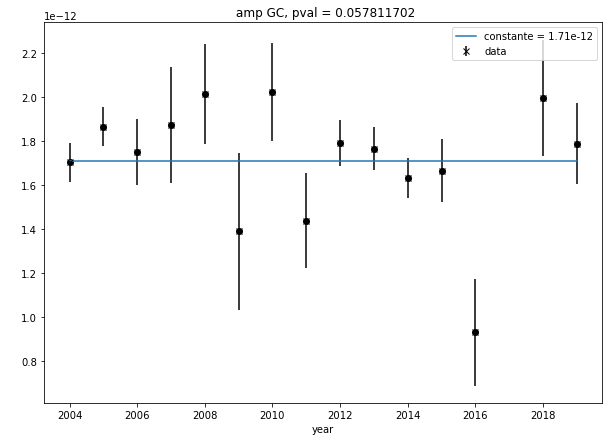

In [134]:
x = years
y = ampsGC
y_uncs = ampsGC_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('year')
plt.ylabel(' ')
plt.legend(loc=1)
plt.title(" amp GC, pval = {0:0.9f}".format(pv))
plt.savefig(pathpar/"ampGC.pdf")

In [135]:
len(ampsGC_err)

15

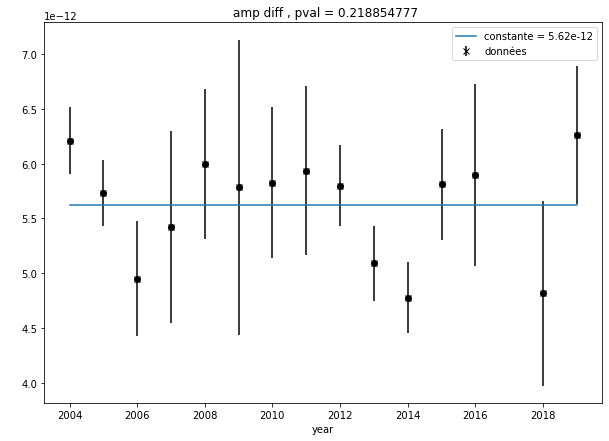

In [136]:
x = years
y = ampsdiff
y_uncs = ampsdiff_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('year')
plt.ylabel(' ')
plt.legend(loc=1)
plt.title(" amp diff , pval = {0:0.9f}".format(pv))
plt.savefig(pathpar/"ampdiff.pdf")

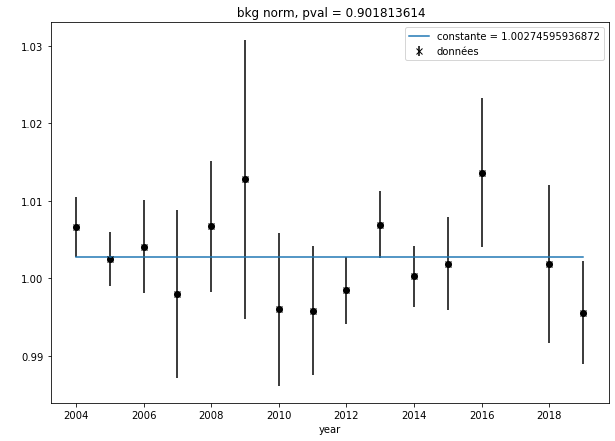

In [137]:
x = years
y = norms
y_uncs = norms_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('year')
plt.ylabel(' ')
plt.legend(loc=1)
plt.title(" bkg norm, pval = {0:0.9f}".format(pv))
plt.savefig(pathpar/"norm.pdf")

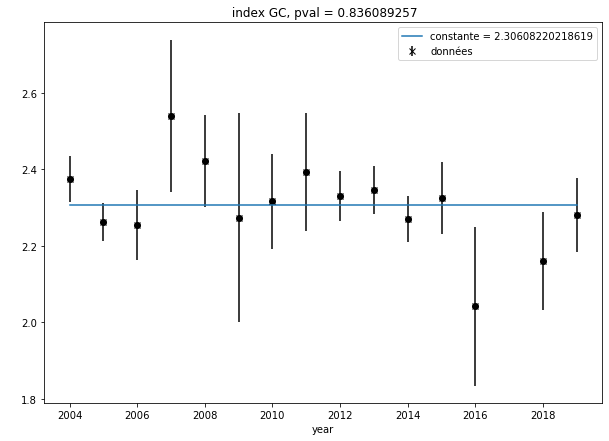

In [138]:
x = years
y = indexGC
y_uncs = indexGC_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('year')
plt.ylabel(' ')
plt.legend(loc=1)
plt.title(" index GC, pval = {0:0.9f}".format(pv))
plt.savefig(pathpar/"index_GC.pdf")

In [139]:
mapdataset_dict[2004].models[2].spectral_model.parameters['index']

Parameter(name='index', value=2.3890424024771093, factor=2.3890424024771093, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=False, id=0x7f964c68c630)

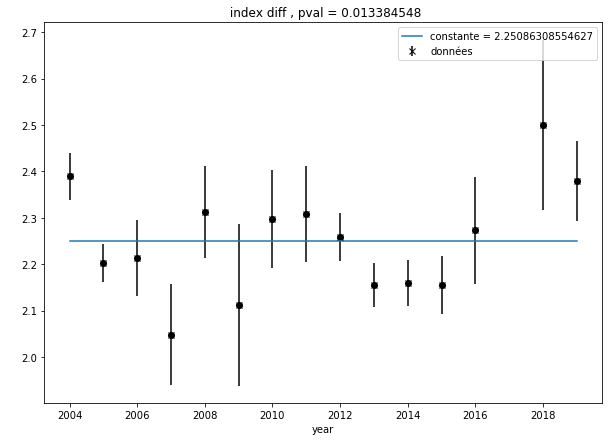

In [140]:
x = years
y = indexdiff
y_uncs = indexdiff_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('year')
plt.ylabel(' ')
plt.legend(loc=1)
plt.title(" index diff , pval = {0:0.9f}".format(pv))
plt.savefig(pathpar/"index_diff.pdf")

In [ ]:
x = years
y = 1/lambdaGC
y_uncs = x*(lambdaGC/lambdaGC_err)

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('year')
plt.ylabel(' ')
plt.legend(loc=1)
plt.title(" E cutoff GC, pval = {0:0.9f}".format(pv))
plt.savefig(pathpar/"cutoff_GC.pdf")

In [ ]:
x = years
y = 1/lambdadiff
y_uncs = x*(lambdadiff/lambdadiff_err)

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('year')
plt.ylabel(' ')
plt.legend(loc=1)
plt.title(" E cutoff diff, pval = {0:0.9f}".format(pv))
plt.savefig(pathpar/"cutoff_diff.pdf")